## Setup

In [2]:
%%javascript
MathJax.Hub.Config({
      TeX: { equationNumbers: { autoNumber: "AMS" } }
    });MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [3]:
from math import exp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Introduction

This notebook will demonstrate how to use the code in the `nnpde1.py` module. The module allows the user to solve an arbitrary 1st-order partial differential equation (PDE) with two variables, and Dirichlet initial conditions, using a single-hidden layer neural network.

This work is based on the paper ["Artificial Neural Networks for Solving Ordinary and Partial Differential Equations", by Lagaris et al, *IEEE Transactions on Neural Networks, Volume 9, No. 5*, September 1998](http://ieeexplore.ieee.org/document/712178/). Note that the notation used in this notebook and the associated Python code differs slightly from that used in the Lagaris paper.

## The algorithm

Consider an $m$-dimensional space containing vectors $\vec x = (x_1,x_2,...,x_m)$. Any 1st-order PDE for the scalar function $\psi(\vec x)$ can be written in the form:

\begin{equation}
G(\vec x,\psi,\vec \nabla \psi) = 0
\end{equation}

The problem is to find a suitable solution to the PDE using a neural network.

The network is trained using a set of $n$ training points $\vec x_i$ ($1 \leq i \leq n$). This work assumes that the vectors $\vec x_i$ have been scaled so that each component $x_{ij} \in [0,\infty)$, $1 \leq j \leq m$. The training points need not be evenly-spaced. Note that only the independent variable vectors $\vec x_i$  of the training points are needed - the estimated value of the solution at the training points is obtained using a trial solution of the form:

\begin{equation}
\psi_t(\vec x_i,\vec p) = A(\vec x_i) + P(\vec x_i) N(\vec x_i,\vec p)
\end{equation}

or:

\begin{equation}
\psi_{ti} = A_i + P_i N_i
\end{equation}

where $\psi_{ti}$ is the value of the trial solution at the current training point $\vec x_i$, $A_i$ is a function which yields the initial conditions at the origin of each dimension, $P_i$ is a function which vanishes at the origin of each dimension, and $N_i$ is the floating-point single-valued output from an unspecified neural network with network parameters $\vec p$. Note that this trial solution satisfies the boundary conditions by construction - at any boundary, the second term vanishes, leaving $\psi_t(\vec x_i, \vec p_i)=A(\vec x_i)$, which is just the specified boundary condition on that boundary. The PDE is assumed to have been preprocessed so that the boundary conditions lie at the origin. For a 2-variable PDE, this condition is represented by:

\begin{equation}
\psi_t(0,y,\vec p) = f_0(y)
\end{equation}

\begin{equation}
\psi_t(x,0,\vec p) = g_0(x)
\end{equation}

The analytical forms of $A(\vec x_i)$ and $P(\vec x_i)$ are then constructed to meet these requirements, and noting that, by continuity at the origin, $f_0(0)=g_0(0)$:

\begin{equation}
A(x,y) = (1-x)f_0(y) + (1-y)(g_0(x) - (1-x)g_0(0))
\end{equation}

\begin{equation}
P(x,y) = x(1-x)y(1-y) = \prod_{j=1}^m x_{ij}(1-x_{ij})
\end{equation}

Training is done in a set of *epochs*. A training epoch consists of presenting the neural network with each of the $n$ training points $\vec x_i$, one at a time. For each input point $\vec x_i$, the network output $N_i$ is computed. Once all $n$ points have been presented, the epoch is complete, and the error function $E$ is computed. The problem definition provides an analytical form for the error function, as the sum of squared errors (SSE) for each of the training points:

\begin{equation}
E = \sum_{i=1}^{n} \left( G(\vec x_i,\psi_{ti}, \vec \nabla \psi_{ti}) \right)^2 =
\sum_{i=1}^{n} G_i^2
\end{equation}

Once this error function is computed, the parameters in the neural network are adjusted to reduce the error. Eventually, a minimum of $E$ is attained, and the resulting final form of $\psi_t(x)$ is used as the solution to the original PDE.

## Computing the network output $N_i$

The neural network used in this work has a simple structure. One input node for each component of $\vec x_i$ is used (for a total of $m$ input nodes) to provide the training data. Each input node is fully-connected to each of a set of $H$ hidden nodes, each using a sigmoid transfer function. Each hidden node is connected to the single output node, which uses a linear transfer function with a weight for the signal from each hidden node.

During each step of a training epoch, the input to the network is just the training point $\vec x_i$. Each input node $j$ receives one component $x_{ij}$, and emits that value as output. These outputs are sent to each of the $H$ hidden nodes. At each hidden node $k$, the input values $x_{ij}$ are combined and scaled by the equation:

\begin{equation}
z_{ik} = \sum_{j=1}^m w_{jk} x_{ij} + u_k
\end{equation}

where  $w_{jk}$ is the weight for input node $j$ at hidden node $k$, and $u_k$ is the bias at hidden node $k$. This combined value is then used as the input to a sigmoidal transfer function:

\begin{equation}
\sigma_{ik} = \sigma(z_{ik})
\end{equation}

where:

\begin{equation}
\sigma(z) = \frac {1}{1+e^{-z}}
\end{equation}

A plot of this transfer function and its first three derivatives is provided below.

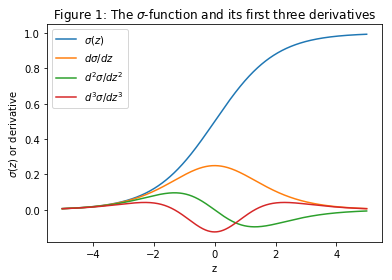

In [4]:
def sigma(z):
    return 1 / (1 + exp(-z))

def dsigma_dz(z):
    return exp(-z) / (1 + exp(-z))**2

def d2sigma_dz2(z):
    return (
        2 * exp(-2 * z) / (1 + exp(-z))**3 - exp(-z) / (1 + exp(-z))**2
    )

def d3sigma_dz3(z):
    return (
        6 * exp(-3 * z) / (1 + exp(-z))**4
        - 6 * exp(-2 * z) / (1 + exp(-z))**3
        + exp(-z) / (1 + exp(-z))**2
    )

z = np.arange(-5, 5, 0.01)
n = len(z)
s = np.zeros(n)
ds_dz = np.zeros(n)
d2s_dz2 = np.zeros(n)
d3s_dz3 = np.zeros(n)
for i in range(n):
    s[i] = sigma(z[i])
    ds_dz[i] = dsigma_dz(z[i])
    d2s_dz2[i] = d2sigma_dz2(z[i])
    d3s_dz3[i] = d3sigma_dz3(z[i])
plt.plot(z,s,label = "$\sigma(z)$")
plt.plot(z,ds_dz,label = "$d\sigma/dz$")
plt.plot(z,d2s_dz2, label = "$d^2\sigma/dz^2$")
plt.plot(z,d3s_dz3, label = "$d^3\sigma/dz^3$");
plt.xlabel("z")
plt.ylabel("$\sigma(z)$ or derivative")
plt.title("Figure 1: The $\sigma$-function and its first three derivatives")
plt.legend();

Once the $\sigma_{ik}$ are computed, they are all passed to the single output node, where they are processed by a linear transfer function to create the network output for the current input point $\vec x_i$:

\begin{equation}
N_i = \sum_{k=1}^{H}v_k\sigma_{ik}
\end{equation}

where $v_k$ is the weight applied to the output from hidden node $k$ at the output node. Once $N_i$ has been computed, the trial function $\psi_{ti}$ is computed. To compute the value of $G_i$ (and thus $E$), we also need the gradient of the trial function $\vec \nabla \psi_{ti}$.

\begin{equation}
\vec \nabla \psi_{ti} = \vec \nabla (A_i + P_i N_i)
\end{equation}

Each component $j$ of this gradient may be written as:

\begin{equation}
\frac {\partial \psi_{ti}}{\partial x_{ij}} =
\frac {\partial A_i}{\partial x_{ij}} + P_i \frac {\partial N_i}{\partial x_{ij}} + \frac {\partial P_i}{\partial x_{ij}} N_i
\end{equation}

The derivatives of $A_i$ and $P_i$ with respect to $x_{ij}$ are computed $\it a \ priori$ from their known analytical forms, which may vary based on the problem under investigation. The values of the network output derivatives $\frac {\partial N_i}{\partial x_{ij}}$ are computed analytically using the known form of the network and its weights and biases.

\begin{equation}
\frac {\partial N_i}{\partial x_{ij}} =
\frac {\partial}{\partial x_{ij}} \sum_{k=1}^{H} v_k \sigma_{ik} =
\sum_{k=1}^{H} v_k \frac {\partial \sigma_{ik}}{\partial x_{ij}} =
\sum_{k=1}^{H} v_k \frac {\partial \sigma_{ik}}{\partial z_{ik}} \frac {\partial z_{ik}}{\partial x_{ij}} = \sum_{k=1}^{H} v_k w_{jk} \sigma_{ik}^{(1)}
\end{equation}

where the derivatives of $\sigma$ are given by:

\begin{equation}
\sigma^{(k)} = \frac {d^k \sigma}{dz^k}
\end{equation}

With the values of $\psi_{ti}$ and $\vec \nabla \psi_{ti}$, we can now compute the values of $G_i$, and then the error function $E$ for the current epoch.

## Updating the network parameters

The network parameters are the weights and biases of the hidden and output nodes. For an $m$-dimensional input point $\vec x_i$, and a set of $H$ hidden nodes, we have a total of $N_p = (m+2)H$ parameters in total: a weight for each $x_{ij}$ for each hidden node, a bias for each hidden node, and an output weight for each hidden node.

Since the objective function to minimize is the error $E$, the value of each network parameter $p_{jk}$ (where $p_{jk}$ represents $v_k$, $u_k$, or $w_{jk}$) is updated using a scaled Newton's method:

\begin{equation}
p_{jk,new}=p_{jk} - \eta \frac {\frac {\partial E}{\partial {p_{jk}}}} {\frac {\partial^2 E}{\partial {p_{jk}^2}}}
\end{equation}

where $\eta$ is the *learning rate* (usually $\eta < 1$). The learning rate is used to reduce the chance of solution instability due to large values of the correction factor in Newton's method. The derivatives of $E$ are computed using the known form of $G_i$, the network, and the network parameters.

This process of parameter updates is repeated until the specified maximum number of training epochs has been applied. Note that the same set of training points is presented during each epoch.

## Computing the derivatives of $E$

The partial derivatives of $E$ with respect to any network parameter $p_{jk}$ is given by:

\begin{equation}
\frac {\partial E}{\partial p_{jk}} =
2 \sum_{i=1}^n G_i \frac {\partial G_i}{\partial p_{jk}}
\end{equation}

\begin{equation}
\frac {\partial^2 E}{\partial p_{jk}^2} =
2 \sum_{i=1}^n \left[G_i \frac {\partial^2 G_i}{\partial p_{jk}^2} + \left(\frac {\partial G_i}{\partial p_{jk}} \right)^2 \right]
\end{equation}

## Computing the derivatives of $G_i$

The partial derivatives of $G_i$ with respect to $x_{ij}$, $\psi_{ti}$, and $\frac {\partial \psi_{ti}} {\partial x_{ij}}$ are determined $\it a\ priori$ from the analytical form of $G$. Note also that $\frac {\partial x_{ij}} {\partial p_{hk}} = 0$. The remaining partial derivatives of $G_i$ are:

\begin{equation}
\frac {d G_i} {d x_{ij}} = \
\frac {\partial G_i} {\partial x_{ij}} + \
\frac {\partial G_i} {\partial \psi_{ti}} \frac {\partial \psi_{ti}} {\partial x_{ij}} + \
\sum_{l=1}^m \frac {\partial G_i} {\partial \left( \frac {\partial \psi_{ti}} {\partial x_{il}} \right)} \
\frac {\partial^2 \psi_{ti}} {\partial x_{ij} \partial x_{il}}
\end{equation}

\begin{equation}
\frac {d^2 G_i} {d x_{ij}^2} = 
\frac {\partial^2 G_i} {\partial x_{ij}^2} + \
\frac {\partial G_i} {\partial \psi_{ti}} \frac {\partial^2 \psi_{ti}} {\partial x_{ij}^2} +
\frac {\partial^2 G_i} {\partial x_{ij} \partial \psi_{ti}} \frac {\partial \psi_{ti}} {\partial x_{ij}} +
\sum_{l=1}^m \left( \frac {\partial G_i} {\partial \left( \frac {\partial \psi_{ti}} {\partial x_{il}} \right)} \
\frac {\partial^3 \psi_{ti}} {\partial x_{ij}^2 \partial x_{il}} + \
\frac {\partial^2 G_i} {\partial x_{ij} \partial \left( \frac {\partial \psi_{ti}} {\partial x_{il}} \right)} \
\frac {\partial^2 \psi_{ti}} {\partial x_{ij} \partial x_{il}} \right)
\end{equation}

\begin{equation}
\frac {\partial G_i}{\partial p_{jk}} =
\frac {\partial G_i}{\partial \psi_{ti}} \frac {\partial \psi_{ti}}{\partial p_{jk}} +
\sum_{l=1}^m \frac {\partial G_i}{\partial \left(\frac {\partial \psi_{ti}}{\partial x_{il}}\right)}
\frac {\partial^2 \psi_{ti}}{\partial p_{jk} \partial x_{il}}
\end{equation}

\begin{equation}
\frac {\partial^2 G_i}{\partial p_{jk}^2} =
\frac {\partial G_i}{\partial \psi_{ti}}
\frac {\partial^2 \psi_{ti}}{\partial p_{jk}^2} +
\frac {\partial^2 G_i}{\partial \psi_{ti}^2} \left(\frac {\partial \psi_{ti}}{\partial p_{jk}}\right)^2 +
\sum_{l=1}^m \left( \frac {\partial G_i}{\partial \left(\frac {\partial \psi_{ti}}{\partial x_{il}}\right)} \frac {\partial^3 \psi_{ti}}{\partial p_{jk}^2 \partial x_{il}} +
\frac {\partial^2 G_i}{\partial \left(\frac {\partial \psi_{ti}}{\partial x_{il}}\right)^2 } \left(\frac {\partial^2 \psi_{ti}}{\partial p_{jk} \partial x_{il}} \right)^2 \right)
\end{equation}

## Computing the derivatives of $\psi_{ti}$

 The derivatives of the trial solution $\psi_{t}$ are given by:

\begin{equation}
\frac {\partial \psi_{ti}} {\partial x_{ij}} = \
\frac {\partial A_i} {\partial x_{ij}} + P_i \frac {\partial N_i} {\partial x_{ij}} + \
\frac {\partial P_i} {\partial x_{ij}} N_i
\end{equation}

\begin{equation}
\frac {\partial^2 \psi_{ti}} {\partial x_{ih} \partial x_{ij}} = \
\frac {\partial^2 A_i} {\partial x_{ih} \partial x_{ij}} + \
P_i \frac {\partial^2 N_i} {\partial x_{ih} \partial x_{ij}} + \
\frac {\partial P_i} {\partial x_{ih}} \frac {\partial N_i} {\partial x_{ij}} + \
\frac {\partial P_i} {\partial x_{ij}} \frac {\partial N_i} {\partial x_{ih}} + \
\frac {\partial^2 P_i} {\partial x_{ih} \partial x_{ij}} N_i
\end{equation}

\begin{equation}
\frac {\partial \psi_{ti}} {\partial p_{jk}} = \
P_i \frac {\partial N_i} {\partial p_{jk}}
\end{equation}

\begin{equation}
\frac {\partial^2 \psi_{ti}} {\partial p_{jk}^2} = \
P_i \frac {\partial^2 N_i} {\partial p_{jk}^2}
\end{equation}

\begin{equation}
\frac {\partial^2 \psi_{ti}} {\partial p_{hk} \partial x_{ij}} = \
P_i \frac {\partial^2 N_i} {\partial p_{hk} \partial x_{ij}} + \
\frac {\partial P_i} {\partial x_{ij}} \frac {\partial N_i} {\partial p_{hk}}
\end{equation}

\begin{equation}
\frac {\partial^3 \psi_{ti}} {\partial p_{hk}^2 \partial x_{ij}} = \
P_i \frac {\partial^3 N_i} {\partial p_{hk}^2 \partial x_{ij}} + \
\frac {\partial P_i} {\partial x_{ij}} \frac {\partial^2 N_i} {\partial p_{hk}^2}
\end{equation}

Note that $A_i$ and $P_i$ are independent of the network parameters $p_{jk}$.

## Computing the derivatives of $N_i$

The partial derivatives of $N_i$ are:

\begin{equation}
\frac {\partial N_i} {\partial x_{ij}} = \sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_{jk}
\end{equation}

\begin{equation}
\frac {\partial^2 N_i} {\partial x_{ij}^2} = \sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_{jk}^2
\end{equation}

\begin{equation}
\frac {\partial N_i}{\partial p_{jk}} =
\sum_{l=1}^H \left( v_l \sigma_{il}^{(1)} \frac {\partial z_{il}}{\partial p_{jk}} + \frac {\partial v_l}{\partial p_{jk}} \sigma_{il} \right)
\end{equation}

\begin{equation}
\frac {\partial^2 N_i}{\partial p_{jk}^2} =
\sum_{l=1}^H \left(
v_l \sigma_{il}^{(1)} \frac {\partial^2 z_{il}}{\partial p_{jk}^2} +
v_l \sigma_{il}^{(2)} \left( \frac {\partial z_{il}}{\partial p_{jk}} \right)^2 +
2 \frac {\partial v_l}{\partial p_{jk}} \sigma_{il}^{(1)} \frac {\partial z_{il}}{\partial p_{jk}} +
\frac {\partial^2 v_l}{\partial p_{jk}^2} \sigma_{il}
\right)
\end{equation}

\begin{equation}
\frac {\partial^2 N_i}{\partial p_{hk} \partial x_{ij}} =
\sum_{l=1}^{H} \left(
v_l \sigma_{il}^{(1)} \frac {\partial w_{jl}} {\partial p_{hk}} + \
v_k \sigma_{il}^{(2)} \frac {\partial z_{il}} {\partial p_{hk}} w_{jl} + \
\frac {\partial v_l} {\partial p_{hk}} \sigma_{il}^{(1)} w_{jl}
\right)
\end{equation}

\begin{equation}
\frac {\partial^3 N_i}{\partial p_{hk}^2 \partial x_i} =
\sum_{l=1}^H
\left(
v_l \sigma_{il}^{(1)} \frac {\partial^2 w_{jl}} {\partial p_{hk}^2} +
v_l \sigma_{il}^{(2)} \frac {\partial z_{il}} {\partial p_{hk}} \frac {\partial w_{jl}} {\partial p_{hk}} +
\frac {\partial v_l} {\partial p_{hk}} \sigma_{il}^{(1)} \frac {\partial w_{jl}} {\partial p_{hk}} +
v_l \sigma_{il}^{(2)} \frac {\partial z_{il}} {\partial p_{hk}} \frac {\partial w_{jl}} {\partial p_{hk}} +
v_l \sigma_{il}^{(2)} \frac {\partial^2 z_{il}} {\partial p_{hk}^2} w_{jl} +
v_l \sigma_{il}^{(3)} \left( \frac {\partial z_{il}} {\partial p_{hk}} \right)^2 w_{jl} +
\frac {\partial v_l} {\partial p_{hk}} \sigma_{il}^{(2)} \frac {\partial z_{il}} {\partial p_{hk}} w_{jl} +
\frac {\partial v_l} {\partial p_{hk}} \sigma_{il}^{(1)} \frac {\partial w_{jl}} {\partial p_{hk}} +
\frac {\partial v_l} {\partial p_{hk}} \sigma_{il}^{(2)} \frac {\partial z_{il}} {\partial p_{hk}} w_{jl} +
\frac {\partial^2 v_l} {\partial p_{hk}^2} \sigma_{il}^{(1)} w_{jl}
\right)
\end{equation}

Most of these expressions can now be simplified using the following relations between the network parameters ($*$ means any index or combination of indices):

\begin{equation}
\frac {\partial v_k}{\partial v_l} = \delta_{kl},
\frac {\partial v_k}{\partial w_*} = \frac {\partial v_k}{\partial u_*} = 0,
\frac {\partial^2 v_k}{\partial p_*^2} = 0
\end{equation}


\begin{equation}
\frac {\partial w_{jk}}{\partial w_{hl}} = \delta_{jh} \delta_{kl},
\frac {\partial w_{jk}}{\partial v_*} = \frac {\partial w_{jk}}{\partial u_*} = 0,
\frac {\partial^2 w_{jk}}{\partial p_*^2} = 0
\end{equation}

\begin{equation}
\frac {\partial u_k}{\partial u_l} = \delta_{kl},
\frac {\partial u_k}{\partial v_*} = \frac {\partial u_k}{\partial w_*} = 0,
\frac {\partial^2 u_k}{\partial p_*^2} = 0
\end{equation}

\begin{equation}
\frac {\partial z_{ik}}{\partial v_*} = 0,
\frac {\partial z_{ik}}{\partial w_{jl}} = x_{ij} \delta_{kl},
\frac {\partial z_{ik}}{\partial u_{jl}} = \delta_{ij} \delta_{kl},
\end{equation}

\begin{equation}
\frac {\partial z_{ik}}{\partial u_l} = \delta_{kl}
\end{equation}

\begin{equation}
\frac {\partial z_{ik}}{\partial w_{jl}} = x_{ij} \delta_{ij} \delta_{kl}
\end{equation}

# Walking through an example problem

Consider the simple 1st-order partial differential equation:

\begin{equation}
G(\vec x, \psi, \vec \nabla \psi) = \frac {\partial \psi}{\partial x} \frac {\partial \psi} {\partial y} - xy = 0
\end{equation}

The analytical solution to this PDE is:

\begin{equation}
\psi(x,y) = xy
\end{equation}

This function is plotted in the following figure:

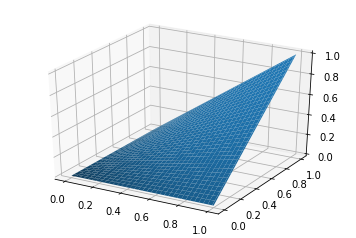

In [5]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
x = np.linspace(0,1,101)
y = np.linspace(0,1,101)
x,y = np.meshgrid(x,y)
psi = x*y
z = psi.reshape(x.shape)
surf = ax.plot_surface(x, y, z)